In [2]:
import os, shutil, random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split


In [1]:
data_dir = "brain_tumor_dataset"
aug_dir = "brain_tumor_augmented"
os.makedirs(aug_dir, exist_ok=True)

datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.1,
                             zoom_range=0.1, horizontal_flip=True, fill_mode='nearest')

for cls in ["yes", "no"]:
    src, dst = os.path.join(data_dir, cls), os.path.join(aug_dir, cls)
    os.makedirs(dst, exist_ok=True)
    images = [os.path.join(src, f) for f in os.listdir(src)]
    
    # Copy originals
    for img_path in images: shutil.copy(img_path, dst)
    
    # Augment until target reached
    count = 250 - len(images)
    while count > 0:
        img = load_img(random.choice(images))
        x = img_to_array(img).reshape((1,) + img.size[::-1] + (3,))
        for _ in datagen.flow(x, batch_size=1, save_to_dir=dst, save_prefix='aug', save_format='jpeg'):
            count -= 1
            break


In [5]:
data_dir = "brain_tumor_augmented"
classes = ["yes", "no"]

base_dir = "brain_tumor_split"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Create directories
for split_dir in [train_dir, val_dir, test_dir]:
    for cls in classes:
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)

# Only keep image files
valid_exts = ('.jpg', '.jpeg', '.png', '.bmp')

for cls in classes:
    src = os.path.join(data_dir, cls)
    images = [os.path.join(src, f) for f in os.listdir(src) if f.lower().endswith(valid_exts)]
    
    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.33, random_state=42)

    for img in train_imgs: shutil.copy(img, os.path.join(train_dir, cls))
    for img in val_imgs: shutil.copy(img, os.path.join(val_dir, cls))
    for img in test_imgs: shutil.copy(img, os.path.join(test_dir, cls))

In [5]:
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.1,
                             zoom_range=0.1, horizontal_flip=True, fill_mode='nearest')

base_dir = "brain_tumor_split"

train_no = len(os.listdir(os.path.join(base_dir, "train/no")))
train_yes = len(os.listdir(os.path.join(base_dir, "train/yes")))

val_no = len(os.listdir(os.path.join(base_dir, "val/no")))
val_yes = len(os.listdir(os.path.join(base_dir, "val/yes")))

test_no = len(os.listdir(os.path.join(base_dir, "test/no")))
test_yes = len(os.listdir(os.path.join(base_dir, "test/yes")))

print("Train - No Tumor:", train_no, " Yes Tumor:", train_yes)
print("Val   - No Tumor:", val_no,   " Yes Tumor:", val_yes)
print("Test  - No Tumor:", test_no,  " Yes Tumor:", test_yes)


Train - No Tumor: 181  Yes Tumor: 175
Val   - No Tumor: 50  Yes Tumor: 50
Test  - No Tumor: 25  Yes Tumor: 25


In [7]:
data_dir = "brain_tumor_augmented"
classes = ["yes", "no"]

base_dir = "brain_tumor_split"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

train_gen = datagen.flow_from_directory(train_dir, target_size=(224,224), batch_size=32, class_mode='binary')
val_gen   = datagen.flow_from_directory(val_dir, target_size=(224,224), batch_size=32, class_mode='binary')
test_gen  = datagen.flow_from_directory(test_dir, target_size=(224,224), batch_size=32, class_mode='binary', shuffle=False)

Found 356 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


# We will be using mobilenet pretrained model for transfer learning then finetune model for better predictions

In [72]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam


In [68]:
img_size = (128, 128)
batch_size = 16
epochs = 10
train_dir = "brain_tumor_split/train"
val_dir = "brain_tumor_split/val"
test_dir = "brain_tumor_split/test"

In [69]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = val_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 356 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [70]:
classes = np.unique(train_gen.classes)
class_weights = compute_class_weight('balanced', classes=classes, y=train_gen.classes)
class_weights = dict(zip(classes, class_weights))

In [73]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))
base_model.trainable = False  # freeze base layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [74]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    class_weight=class_weights
)

C:\Users\Muskan Kirti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 322ms/step - accuracy: 0.4834 - loss: 0.9011 - val_accuracy: 0.7200 - val_loss: 0.5059
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 240ms/step - accuracy: 0.6279 - loss: 0.6624 - val_accuracy: 0.8100 - val_loss: 0.4201
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 0.7587 - loss: 0.4907 - val_accuracy: 0.8600 - val_loss: 0.3732
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.7751 - loss: 0.4462 - val_accuracy: 0.8800 - val_loss: 0.3404
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step - accuracy: 0.7776 - loss: 0.4572 - val_accuracy: 0.8900 - val_loss: 0.3214
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.8783 - loss: 0.3870 - val_accuracy: 0.8900 - val_loss: 0.3114
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.8229 - loss: 0.4069 - val_accuracy: 0.8800 - val_loss: 0.3007
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step - accuracy: 0.8515 - loss: 0.3572 - val_accuracy: 0

In [75]:
loss, acc = model.evaluate(test_gen, steps=len(test_gen))
print(f"Test Accuracy: {acc*100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.8027 - loss: 0.4605
Test Accuracy: 84.00%


In [76]:
preds = model.predict(test_gen, steps=len(test_gen))
pred_labels = (preds > 0.5).astype(int)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 618ms/step


We will be doing fine tuning as of now

In [77]:
# Unfreeze last few layers of base model
base_model.trainable = True

# Freeze all layers except last 20 
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,   # usually fewer epochs
    class_weight=class_weights
)

Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 339ms/step - accuracy: 0.7646 - loss: 0.5023 - val_accuracy: 0.8800 - val_loss: 0.2793
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 262ms/step - accuracy: 0.8436 - loss: 0.3953 - val_accuracy: 0.8700 - val_loss: 0.2820
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 251ms/step - accuracy: 0.8281 - loss: 0.3877 - val_accuracy: 0.8700 - val_loss: 0.2823
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.7807 - loss: 0.4251 - val_accuracy: 0.8600 - val_loss: 0.2814
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - accuracy: 0.8360 - loss: 0.3483 - val_accuracy: 0.8700 - val_loss: 0.2746


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000021E66C6B740> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 599ms/step


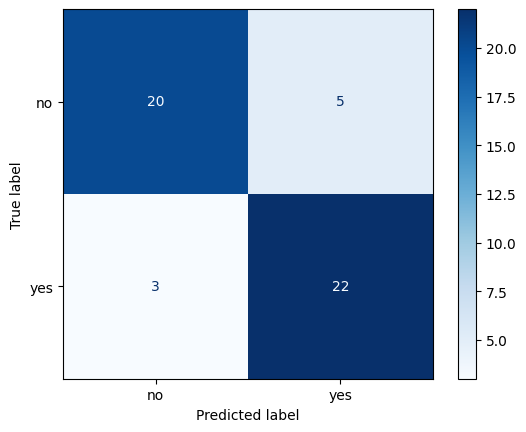

In [78]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing import image

# Make predictions (probabilities)
pred_probs = model.predict(test_gen, steps=len(test_gen))

# Convert probabilities to 0/1 labels
pred_labels = (pred_probs > 0.5).astype(int).flatten()

# True labels
true_labels = test_gen.classes

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(cm, display_labels=list(test_gen.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [89]:
def predict_single_image(img_path, model, img_size=(128,128)):
    
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0  # normalize
    x = np.expand_dims(img_array, axis=0)  # add batch dimension

    
    pred = model.predict(x)
    label = "Yes Tumor" if pred[0][0] > 0.5 else "No Tumor"
    print(f"Prediction: {label}, Probability: {pred[0][0]:.4f}")

    plt.imshow(img_array.astype('float32'))
    plt.axis('off')
    plt.title(f"Prediction: {label}")
    plt.show()

    return label

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Prediction: Yes Tumor, Probability: 0.8273


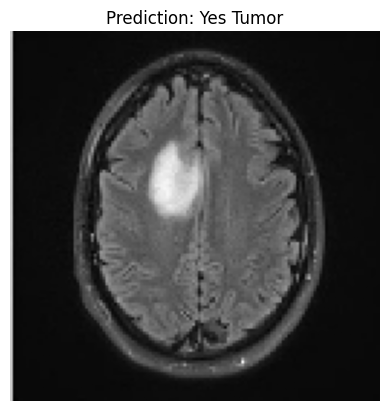

'Yes Tumor'

In [90]:
img_path = "brain_tumor_split/test/yes/Y8.jpg"
predict_single_image(img_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Prediction: No Tumor, Probability: 0.0170


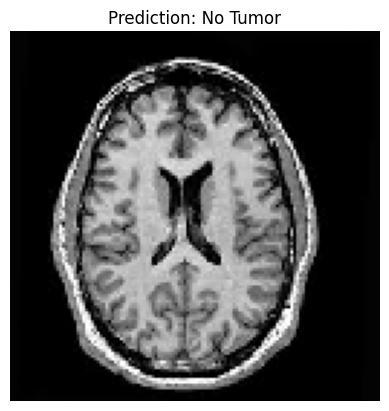

'No Tumor'

In [92]:
img_path = "brain_tumor_split/test/no/25 no.jpg"
predict_single_image(img_path, model)